<a href="https://colab.research.google.com/github/comparativechrono/Rephasing-of-Seasonal-Birth-Rates-in-the-United-Kingdom-/blob/main/Supplemental_material/SI_figure_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1953–1974 light: peak lag = -22 mo, r = 0.096, ns (|r|>0.123)
1953–1974 temp: peak lag = -24 mo, r = -0.110, ns (|r|>0.123)
1976–2014 light: peak lag = -16 mo, r = 0.092, ns (|r|>0.092)
1976–2014 temp: peak lag = -3 mo, r = -0.072, ns (|r|>0.092)


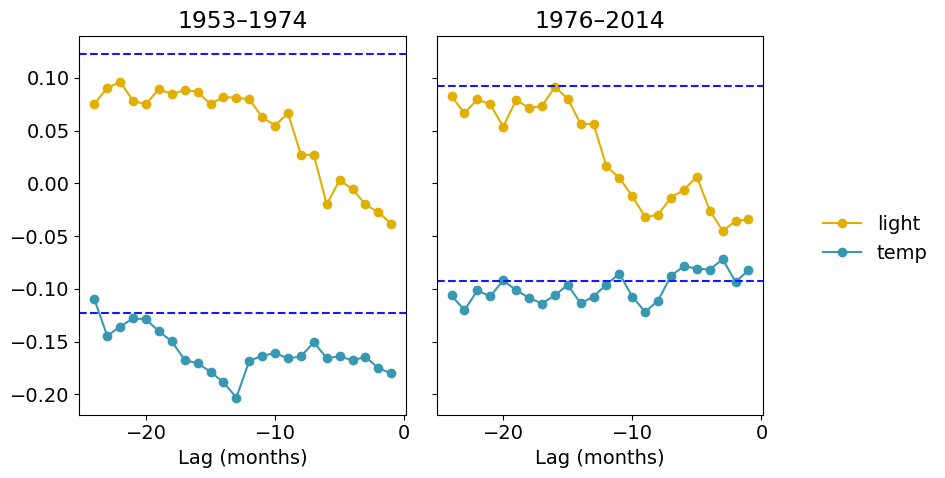

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


# ------------------------------------------------------------------
# 1. Load the two time periods
# ------------------------------------------------------------------
# data_pre: 1953–1974; data_post: 1976–2014
data_pre = pd.read_csv("https://raw.githubusercontent.com/comparativechrono/Rephasing-of-Seasonal-Birth-Rates-in-the-United-Kingdom-/main/time-series/1953-74.csv")
data_post = pd.read_csv("https://raw.githubusercontent.com/comparativechrono/Rephasing-of-Seasonal-Birth-Rates-in-the-United-Kingdom-/main/time-series/1976-2014.csv")

# Ensure columns: 'BR' (birth rate), 'light' (photoperiod), 'temp' (temperature)
for df in (data_pre, data_post):
    df["BR"]    = pd.to_numeric(df["BR"],   errors="coerce")
    df["light"] = pd.to_numeric(df["light"],errors="coerce")
    df["temp"]  = pd.to_numeric(df["temp"], errors="coerce")
    df.dropna(inplace=True)

# ------------------------------------------------------------------
# 1. Deseasonalize each series with STL (period=12)
# ------------------------------------------------------------------
def deseasonalize(series):
    stl = STL(series, period=12, robust=True).fit()
    return series - stl.seasonal

data_pre['BR_resid']    = deseasonalize(data_pre['BR'])
data_pre['light_resid']= deseasonalize(data_pre['light'])
data_pre['temp_resid']  = deseasonalize(data_pre['temp'])

data_post['BR_resid']    = deseasonalize(data_post['BR'])
data_post['light_resid']= deseasonalize(data_post['light'])
data_post['temp_resid']  = deseasonalize(data_post['temp'])

# ------------------------------------------------------------------
# 2. Compute CCF on residuals over lags -18 to -6 (biologically plausible window)
# ------------------------------------------------------------------
def compute_ccf_resid(df, var_resid, br_resid, lags):
    n = len(df)
    ccf_vals = []
    for lag in lags:
        if lag < 0:
            x = df[var_resid].values[:lag]
            y = df[br_resid].values[-lag:]
        elif lag > 0:
            x = df[var_resid].values[lag:]
            y = df[br_resid].values[:-lag]
        else:
            x = df[var_resid].values
            y = df[br_resid].values
        ccf_vals.append(np.corrcoef(x, y)[0,1])
    return np.array(ccf_vals)

lags = np.arange(-24, 0)  # test lags -18, -17, ..., -6

for period, df in [('1953–1974', data_pre), ('1976–2014', data_post)]:
    for var in ['light_resid', 'temp_resid']:
        vals = compute_ccf_resid(df, var, 'BR_resid', lags)
        peak_idx = np.nanargmax(vals)
        peak_lag = lags[peak_idx]
        peak_r   = vals[peak_idx]
        # significance threshold approx ±2/√N
        thresh = 2/np.sqrt(len(df))
        sig      = abs(peak_r) > thresh
        print(f"{period} {var.split('_')[0]}: peak lag = {peak_lag} mo, r = {peak_r:.3f}, "
              f"{'significant' if sig else 'ns'} (|r|>{thresh:.3f})")

# ------------------------------------------------------------------
# 3. Plot CCFs for residuals – one shared legend on the right
# ------------------------------------------------------------------

plt.rcParams.update({'font.size': 14})   # 14 pt everywhere – change to taste

fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

handles, labels = [], []          # collect one copy of each entry

for ax, (period, df) in zip(axes, [('1953–1974', data_pre),
                                   ('1976–2014', data_post)]):
    for var, color in [('light_resid', '#e1af04'),
                       ('temp_resid',  '#3898b2')]:
        vals = compute_ccf_resid(df, var, 'BR_resid', lags)
        line, = ax.plot(lags, vals, label=var.split('_')[0], marker='o', color=color)

        # store a single copy of each handle/label for the common legend
        if line.get_label() not in labels:
            handles.append(line)
            labels.append(line.get_label())

    ax.axhline( 2/np.sqrt(len(df)), color='#1717ff', linestyle='--')
    ax.axhline(-2/np.sqrt(len(df)), color='#1717ff', linestyle='--')
    ax.set_title(period)
    ax.set_xlabel('Lag (months)')

# ----- place a single legend to the right of both sub-plots
fig.subplots_adjust(right=0.8)  # leave room on the right
fig.legend(handles, labels,
           loc='center left',      # middle right edge of the figure
           bbox_to_anchor=(1.02, 0.5),
           frameon=False)

plt.tight_layout()
plt.show()
